In [1]:
DATA = '../data'
IMAGES_PATH = 'images'
MASKS_PATH = 'masks'
INSTANCES_PATH = 'instance_masks'
WIDHT , HEIGHT = 224, 224
CHANNELS = 3

In [2]:
import os
import imageio
import numpy as np
import pandas as pd
import geopandas as gp
from sklearn.model_selection import StratifiedShuffleSplit


def get_data_pathes(
    datasets_path, images_path_name='images',
    masks_path_name='masks', instances_path_name='instance_masks'
    ):
    
    datasets = list(os.walk(datasets_path))[0][1]
    data_pathes = []
    for dataset in datasets:
        data_pathes.append((
            os.path.join(datasets_path, dataset, images_path_name),
            os.path.join(datasets_path, dataset, masks_path_name),
            os.path.join(datasets_path, dataset, instances_path_name)))
    
    return data_pathes


def get_instances(instances_path):
    return list(os.walk(instances_path))[0][1]


def image2mask(image_path, image_type):
    return imageio.imread('{}.{}'.format(image_path, image_type))


def get_data(
    images_path, masks_path, instances,
    img_type='jpeg', msk_type='png'
    ):

    X = np.array([
        image2mask(os.path.join(images_path, i), img_type) for i in instances])
    y = np.array([
        image2mask(os.path.join(masks_path, i), msk_type)for i in instances])
    y = y.reshape([*y.shape, 1])
    
    return X, y


def get_area(instance_path):
    return (gp.read_file(instance_path)['geometry'].area / 100).median()

    
def get_labels(distr):
    res = np.full(distr.shape, 3)
    res[distr < np.quantile(distr, 0.75)] = 2
    res[distr < np.quantile(distr, 0.5)] = 1
    res[distr < np.quantile(distr, 0.25)] = 0
    return res


def stratify(datasets_path, test_size, random_state):
    datasets = get_data_pathes(datasets_path)
    images_path, masks_path, instances_path = datasets[0]
    instances = list(os.walk(instances_path))[0][1]
    X, _ = get_data(images_path, masks_path, instances)
    areas = np.array([
        get_area(os.path.join(instances_path, i, i + '.geojson')) for i in instances])
    labels = get_labels(areas)

    sss = StratifiedShuffleSplit(
        n_splits=len(datasets), test_size=test_size, random_state=random_state)
    
    return sss.split(X, labels)


def build_stratified_generator(train_, test_size=0.2, random_state=42):
    stratified_ix = stratify(datasets_path, test_size, random_state)
    datasets = get_data_pathes(datasets_path) 
    for i, (train_ix, test_ix) in enumerate(stratified_ix):
        images_path, masks_path, instances_path = datasets[i]
        instances = list(os.walk(instances_path))[0][1]
        X, y = get_data(images_path, masks_path, instances)
        
        yield X[train_ix], y[train_ix], X[test_ix], y[test_ix]

In [63]:
def stratified_split(datasets_path, test_size=0.2, random_state=42):
    cols = [
        'name',
        'image_path', 'mask_path', 'instance_path',
        'image_type', 'mask_type'
    ]
    stratified_ix = stratify(datasets_path, test_size, random_state)
    train_df = pd.DataFrame(columns=cols)
    test_df = pd.DataFrame(columns=cols)
    datasets = get_data_pathes(datasets_path)
    for i, (train_ix, test_ix) in enumerate(stratified_ix):
        images_path, masks_path, instances_path = datasets[i]
        instances = list(os.walk(instances_path))[0][1]
        image_type = list(os.walk(images_path))[0][2][0].split('.')[-1]
        mask_type = list(os.walk(masks_path))[0][2][0].split('.')[-1]
    
        train_df = train_df.append(pd.DataFrame({
            'name': np.array(instances)[train_ix],
            'image_path': images_path,
            'mask_path': masks_path,
            'instance_path': instances_path,
            'image_type': image_type,
            'mask_type': mask_type
        }), sort=False, ignore_index=True)
        
        test_df = test_df.append(pd.DataFrame({
            'name': np.array(instances)[test_ix],
            'image_path': images_path,
            'mask_path': masks_path,
            'instance_path': instances_path,
            'image_type': image_type,
            'mask_type': mask_type
        }), sort=False, ignore_index=True)
    
    return train_df, test_df

In [64]:
train_df, test_df = stratified_split(DATA)

In [65]:
train_df.to_csv('../data/train_df.csv')
test_df.to_csv('../data/test_df.csv')

In [70]:
def build_batch_generator(files_df, batch_size=4):
    while True:
        for start in range(0, files_df.shape[0], batch_size):
            images = []
            masks = []
            end = min(start + batch_size, files_df.shape[0])
            train_batch = files_df.iloc[start:end]

            for ix, file in train_batch.iterrows():
                image_path = os.path.join(
                    file['image_path'],
                    '{}.{}'.format(file['name'], file['image_type']))
                mask_path = os.path.join(
                    file['mask_path'],
                    '{}.{}'.format(file['name'], file['mask_type']))

                img = imageio.imread(image_path)
                mask = imageio.imread(mask_path)

                images.append(img)
                masks.append(mask)

            images = np.array(images, np.float32)
            masks = np.array(masks, np.float32)
            masks = masks.reshape(*masks.shape, 1)

            yield images, masks

In [71]:
gen = build_batch_generator(train_df, 4)
j = 0
a = []
for i in gen:
    a.append(i)
    print(i[0].shape)
    print(i[1].shape)
    if j == 2:
        break
    j += 1

(4, 224, 224, 3)
(4, 224, 224, 1)
(4, 224, 224, 3)
(4, 224, 224, 1)
(4, 224, 224, 3)
(4, 224, 224, 1)


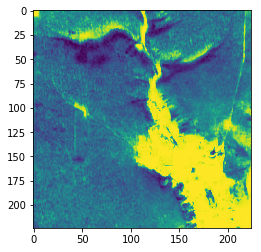

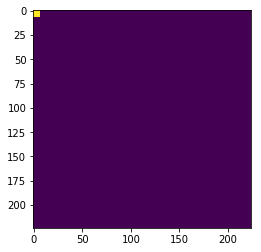

In [77]:
import matplotlib.pyplot as plt
plt.imshow(a[1][0][0,:,:,2])
plt.show()
plt.imshow(a[1][1][0,:,:,0])

In [78]:
train_generator = build_batch_generator(train_df, 4)
val_generator = build_batch_generator(test_df, 4)

In [79]:
import threading


def freeze_model(model, freeze_before_layer):
    if freeze_before_layer == "ALL":
        for l in model.layers:
            l.trainable = False
    else:
        freeze_before_layer_index = -1
        for i, l in enumerate(model.layers):
            if l.name == freeze_before_layer:
                freeze_before_layer_index = i
        for l in model.layers[:freeze_before_layer_index]:
            l.trainable = False

class ThreadsafeIter(object):
    def __init__(self, it):
        self.lock = threading.Lock()
        self.it = it.__iter__()

    def __iter__(self): return self

    def __next__(self):
        with self.lock:
            return next(self.it)

In [80]:
from segmentation_models import Unet
from segmentation_models.backbones import get_preprocessing
from segmentation_models.losses import bce_dice_loss
from segmentation_models.metrics import dice_score
import math 

BACKBONE = 'resnet50'
EPOCHS = 10
BATCH = 4
preprocess_input = get_preprocessing(BACKBONE)

model = Unet(BACKBONE, encoder_weights='imagenet')
model.compile('Adam', loss=bce_dice_loss, metrics=[dice_score])

In [81]:
model.fit_generator(
    ThreadsafeIter(train_generator),
    steps_per_epoch=math.ceil(train_df.shape[0] / BATCH),
    epochs = 10,
    validation_data=ThreadsafeIter(val_generator),
    validation_steps=math.ceil(test_df.shape[0] / BATCH),
    max_queue_size=50,
    workers=4
)

Epoch 1/10
49/49 [==============================] - 229s 5s/step - loss: 1.0938 - score: 0.1394 - val_loss: 1.3525 - val_score: 0.0343
Epoch 2/10
49/49 [==============================] - 143s 3s/step - loss: 0.7832 - score: 0.3204 - val_loss: 0.9780 - val_score: 0.2583
Epoch 3/10
49/49 [==============================] - 140s 3s/step - loss: 0.7026 - score: 0.4009 - val_loss: 15.1306 - val_score: 0.0527
Epoch 4/10
49/49 [==============================] - 141s 3s/step - loss: 0.6884 - score: 0.4186 - val_loss: 3.1570 - val_score: 0.0719
Epoch 5/10
49/49 [==============================] - 140s 3s/step - loss: 0.6173 - score: 0.4824 - val_loss: 1.1790 - val_score: 0.1922
Epoch 6/10
49/49 [==============================] - 140s 3s/step - loss: 0.5801 - score: 0.5173 - val_loss: 8.9591 - val_score: 0.1226
Epoch 7/10
49/49 [==============================] - 139s 3s/step - loss: 0.5857 - score: 0.5152 - val_loss: 0.9020 - val_score: 0.3190
Epoch 8/10
49/49 [==============================] - 14